# Can Student Exam Performance Accurately Predict the Student's Knowledge Level in that Material?

### DSCI 100 006

Jezarah Ebel, Guanlin Pu, Junhao Wen

## 1.0 Introduction

  Generally speaking, electrical machines are divided into AC Machines and DC Machines. A DC Machine is an electromechanical device that can simultaneously convert electrical energy into mechanical energy or mechanical energy into kinetic energy. The DC Machine actually converts alternating current from one voltage level to another. It works by placing a current-carrying conductor coil in a magnetic field, and generating a mechanical force, called torque, that drives the conductor coil to rotate in this magnetic field. Since this is a brand new technology for students, their knowledge of it varies depending on a number of factors in the learning process. When teaching complex subjects, educators have been experimenting and theorizing about the use of various technologies. We will research the real dataset about the undergraduate students’ knowledge status about the subject of Electrical DC Machines.
  
The question we investigate is predictive: can we use the user performance in exams (PEG) to predict students' knowledge level (UNS)?

Answering this question is very useful and important because it can help educators to formulate more reasonable and effective learning plans for students through quantitative answers, and prevent students from using ineffective learning methods.

For example, Tomic and Milic (2013) introduce software that uses data visualizations to help students better understand teaching materials. Through the evaluation results of students, it is shown that this kind of use of data visualization teaching software is useful and effective for students' memory (Tomic & Milic, 2013). While there is still some room for discussion about specific types of software, it allows students to improve their knowledge and provides a faster way to learn and receive feedback on performance.

The data set we use for our group project is a user knowledge modeling data set, which was developed by Kahraman, Sagiroglu, and Colak for 403 undergraduate students of Electrical Education of Gazi University in 2009. This data set collects student's features and classifies the student's knowledge into 4 levels, and study time, repetition, relevance, and exam performance are all important factors that relate to students’ knowledge level. User modeling is one of the most powerful mechanisms for network-based adaptation, so researchers use user (student) information to tailor topics based on their knowledge. Therefore, the purpose of the user modeling system is to provide users (students) with sufficient and appropriate knowledge for them to learn (Kahraman et al., 2013).

## 2.0 Methods & Results

To complete the analysis of the research question, it is necessary to systematically investigate the dataset following intentional steps that lead us to a robust final answer. Following is a detailed presentation of a K-nearest neighbors classification from data loading to modelling of the classifier and maximization of the classifiers accuracy using cross-validation. Please run the following cell before the rest of the report in order to import the necessary libraries used for the analysis. 

In [38]:
# Run this cell before continuing  
library(tidyverse)
library(tidymodels)
library(stringr)
library(rvest)
library(readxl)
library(dplyr)
library(knitr)
library(cowplot)
library(repr)
options(repr.matrix.max.rows = 6)

### 2.1 Reading

The first step to answer this question, is to download the file from the User Knowledge Modeling Data Set using the `download.file` function and saving it locally. 

In [39]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "uk_data.xls")

Now that the excel file has been downloaded, the `excel_sheets` function is used to find the sheet names as this file has multiple sheets. 

In [40]:
sheets <- excel_sheets("uk_data.xls")
sheets

[1] "Information"   "Training_Data" "Test_Data"

### 2.2 Wrangling and Cleaning

As indicated by the sheet titles, this dataset is already split into training and test data, however moving forward it's important to ensure that each set has similar proportion of each UNS (The knowledge level of user) categories. The instances for each category in both the training and testing datasets can be counted using `group_by` and `summarize`. Also notice that in the testing data the Very Low UNS category is displayed as very_low, to keep the data consistent across both sets we replace very_low with Very Low in the training set.

In [41]:
initial_training_data <- read_excel("uk_data.xls", sheet = "Training_Data", range = cell_cols("A:F"))
initial_training_data[initial_training_data  == "very_low"] <- "Very Low" 
initial_training_data <- initial_training_data  %>%
        mutate(UNS = as_factor(UNS))
initial_testing_data <- read_excel("uk_data.xls", sheet = "Test_Data", range = cell_cols("A:F")) %>%
        mutate(UNS = as_factor(UNS))
initial_training_summary <- initial_training_data %>%
                group_by(UNS) %>%
                summarize(n = n()) %>%
                mutate(proportion = (n / 258) * 100) %>%
                arrange(desc(n)) 
initial_testing_summary <- initial_testing_data %>%
                group_by(UNS) %>%
                summarize(n = n()) %>%
                mutate(proportion = (n / 145) * 100) %>%
                arrange(desc(n))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [42]:
kable(initial_training_summary, caption = "1 UNS Counts for Training Dataset")
kable(initial_testing_summary, caption = "2 UNS Counts for Testing Dataset")



Table: 1 UNS Counts for Training Dataset

|UNS      |  n| proportion|
|:--------|--:|----------:|
|Middle   | 88|  34.108527|
|Low      | 83|  32.170543|
|High     | 63|  24.418605|
|Very Low | 24|   9.302326|



Table: 2 UNS Counts for Testing Dataset

|UNS      |  n| proportion|
|:--------|--:|----------:|
|Low      | 46|   31.72414|
|High     | 39|   26.89655|
|Middle   | 34|   23.44828|
|Very Low | 26|   17.93103|

The distribution of UNS values in the training data and testing data is not approximately equal as illustrated above, therefore to get better results for  now we will combine the training and testing datasets given into one dataset (using `rbind`). At this point, we also remove any NA values from the dataset.

In [43]:
total_data <- rbind(initial_training_data, initial_testing_data)

### 2.3 Summarization of the Data

In [44]:
total_data_head <- head(total_data)
kable(total_data_head, caption = "3 User Knowledge Dataset")



Table: 3 User Knowledge Dataset

|  STG|  SCG|  STR|  LPR|  PEG|UNS      |
|----:|----:|----:|----:|----:|:--------|
| 0.00| 0.00| 0.00| 0.00| 0.00|Very Low |
| 0.08| 0.08| 0.10| 0.24| 0.90|High     |
| 0.06| 0.06| 0.05| 0.25| 0.33|Low      |
| 0.10| 0.10| 0.15| 0.65| 0.30|Middle   |
| 0.08| 0.08| 0.08| 0.98| 0.24|Low      |
| 0.09| 0.15| 0.40| 0.10| 0.66|Middle   |

In [45]:
total_data_summary <- total_data %>%
                group_by(UNS) %>%
                summarize(n = n()) 

total_data_summary_wider <- pivot_wider(total_data_summary, names_from = UNS, values_from = n)

summary_stats <- summarize(total_data,  mean_STG = mean(STG), mean_SCG = mean(SCG),  mean_STR = mean(STR), mean_LPR = mean(LPR), mean_PEG = mean(PEG))

final_summary <- merge(summary_stats, total_data_summary_wider)

kable(final_summary, caption = "4 Summary Table")

`summarise()` ungrouping output (override with `.groups` argument)





Table: 4 Summary Table

|  mean_STG|  mean_SCG|  mean_STR|  mean_LPR|  mean_PEG| Very Low| High| Low| Middle|
|---------:|---------:|---------:|---------:|---------:|--------:|----:|---:|------:|
| 0.3531414| 0.3559404| 0.4576551| 0.4313424| 0.4563598|       50|  102| 129|    122|

### 2.4 Visualizing the Data

To answer our question and visualize what variables in the dataset are likely to be good predictors of the user knowledge level (UNS). We can visualize the data using histograms and color code by the UNS variable.  

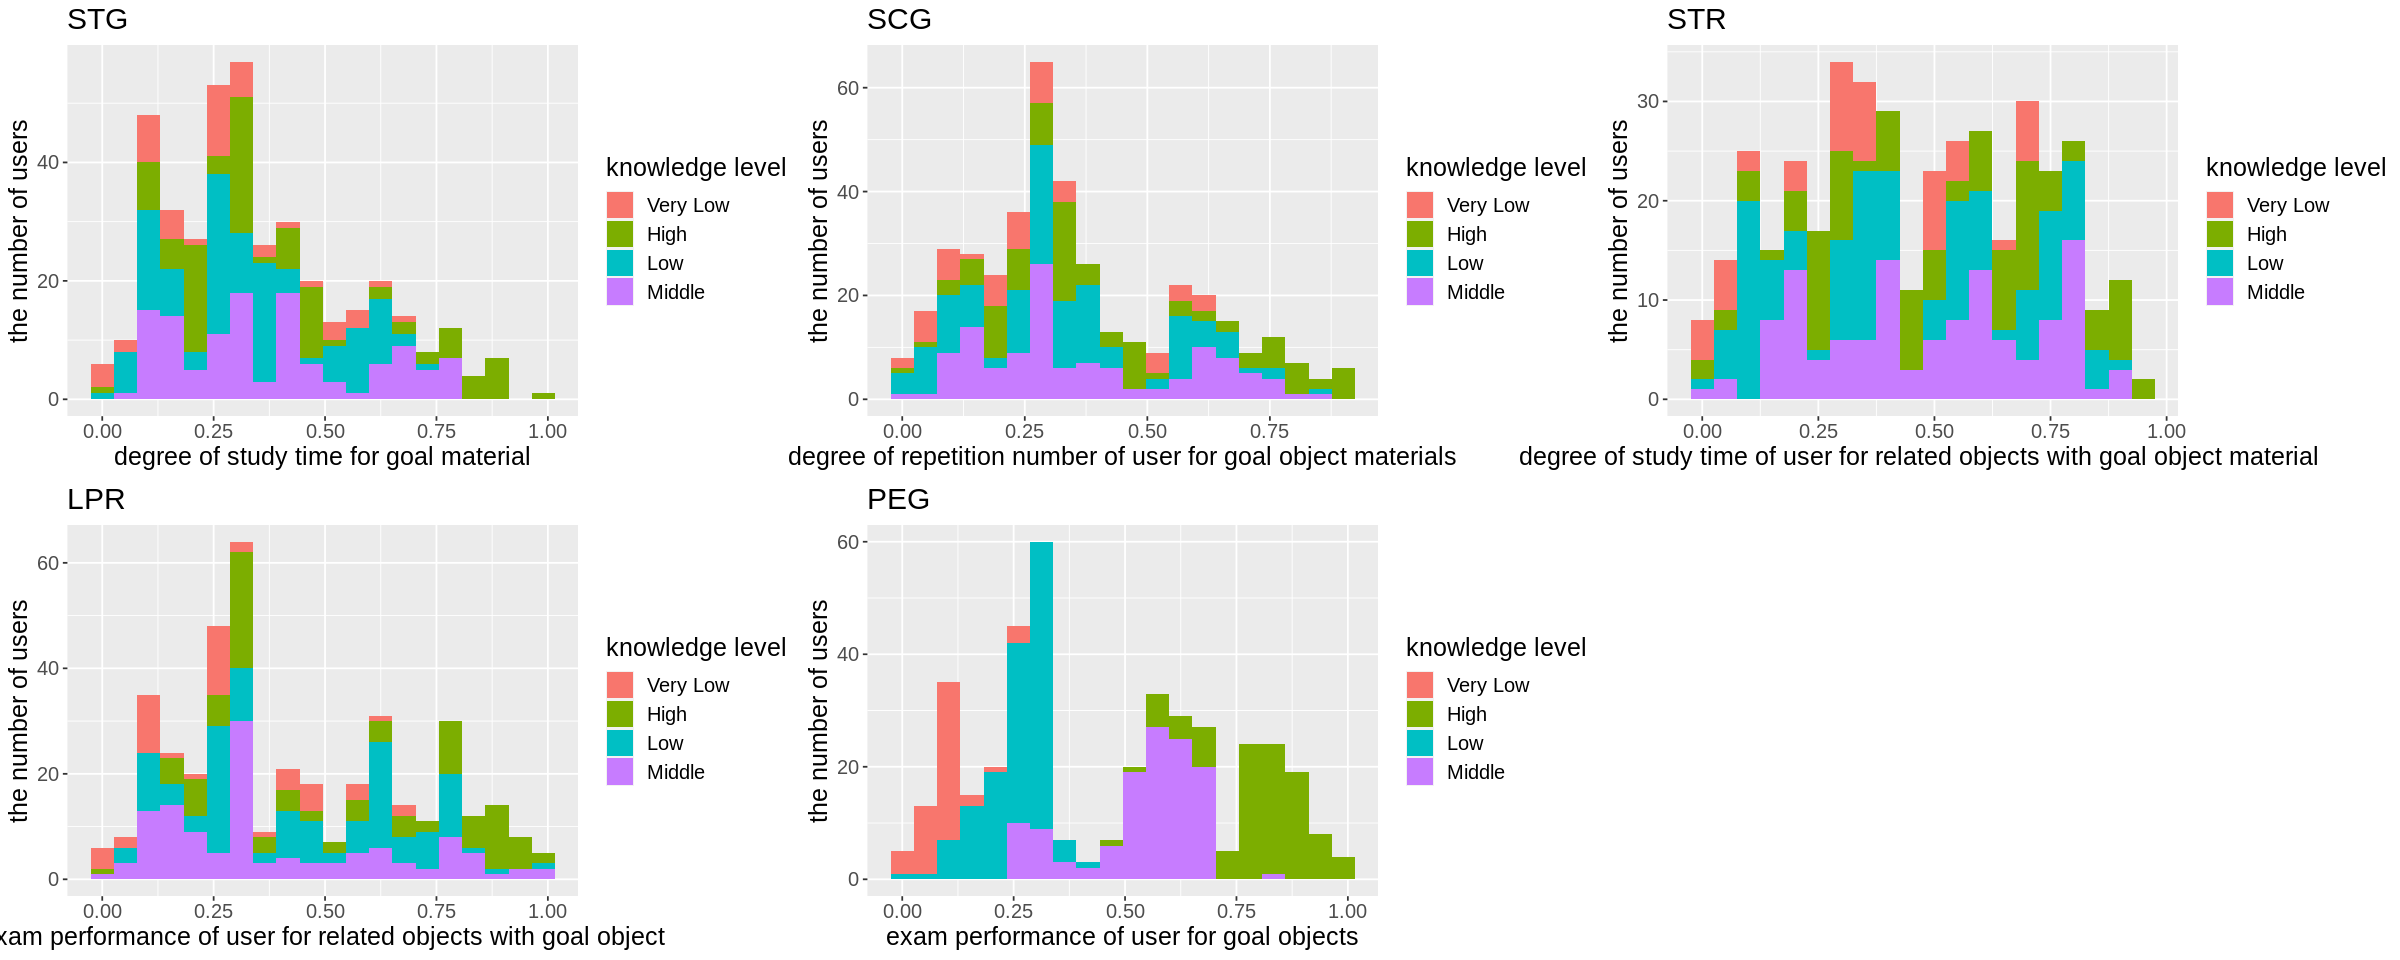

In [46]:
options(repr.plot.height = 8, repr.plot.width = 20)
STG_hist <- ggplot(total_data, aes(x = STG, fill = UNS, stat= "identity")) +
            geom_histogram(bins = 20) +
            labs(x="degree of study time for goal material", y="the number of users",fill="knowledge level", title = "") +
            ggtitle("STG") +
            theme(text = element_text(size = 15))
SCG_hist <- ggplot(total_data, aes(x = SCG, fill = UNS, stat= "identity")) +
            ggtitle("SCG") +
            geom_histogram(bins = 20) +
            labs(x="degree of repetition number of user for goal object materials", y="the number of users",fill="knowledge level")+
            theme(text = element_text(size = 15))
STR_hist <- ggplot(total_data, aes(x = STR, fill = UNS, stat= "identity")) +
            ggtitle("STR") +
            geom_histogram(bins = 20) +
            labs(x="degree of study time of user for related objects with goal object material ", y="the number of users",fill="knowledge level")+
            theme(text = element_text(size = 15))
LPR_hist <- ggplot(total_data, aes(x = LPR, fill = UNS, stat= "identity")) +
            ggtitle("LPR") +
            geom_histogram(bins = 20) +
            labs(x="exam performance of user for related objects with goal object", y="the number of users",fill="knowledge level")+
            theme(text = element_text(size = 15))
PEG_hist <- ggplot(total_data, aes(x = PEG, fill = UNS, stat= "identity")) +
            ggtitle("PEG") +
            geom_histogram(bins = 20) +
            labs(x="exam performance of user for goal objects", y="the number of users",fill="knowledge level")+
            theme(text = element_text(size = 15))
plot_grid(STG_hist, SCG_hist, STR_hist, LPR_hist, PEG_hist, ncol = 3)

*Figure 1: Histograms showing the spread of each variable and the proportions with the knowledge levels*

From the histograms, we can see that in terms of the student's knowledge, a pattern can be most seen with the exam performance thus we will perform a K-nearest neighbors classification model in order to see if the exam performance of user for goal object or PEG will be an accurate predictor for the knowledge level or UNS. 

### 2.5 Data Preprocessing 

The `initial_split` function shuffles and straitifies the data then splits it with approximately equal proportions (for the specified strata) across the training and testing data.  

In [47]:
uk_split <- initial_split(total_data, prop = 0.7, strata = UNS)
training_data <- training(uk_split)
testing_data <- testing(uk_split)

Now that we've compiled the data into a total dataset, tidied and split it into training and testing data. When we use K-nearest classification, the scale for the dataset predictors is important. Additionally, the center (or mean) of each predictor is also significant. By standardizing our data we can control the impact of each predictor on the model. Use `step_scale` and `step_center` to standardize each variable to have a mean of 0 and a standard deviation of 1. 

In [48]:
uk_recipe <- recipe(UNS ~ PEG, data = training_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

### 2.6 5-Fold Cross Validation

So far, we split the training and testing datasets as well as preprocessed the data. Now, let's create our K-nearest neighbour classifier.

In [62]:
set.seed(3000) # DO NOT REMOVE

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

To tune the model, we want to maximize the performance of our classifier on data *it hasn’t seen yet*. The next task is to perform a 5-fold cross-validation using the `vfold_cv` function.

In [63]:
set.seed(3000) # DO NOT REMOVE

uk_vfold <- vfold_cv(training_data, v = 5 , strata = UNS)

The next step is to perform the workflow analysis using the `uk_recipe` and the `knn_spec` objects we made earlier and using the `fit_resamples` function for training. 

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


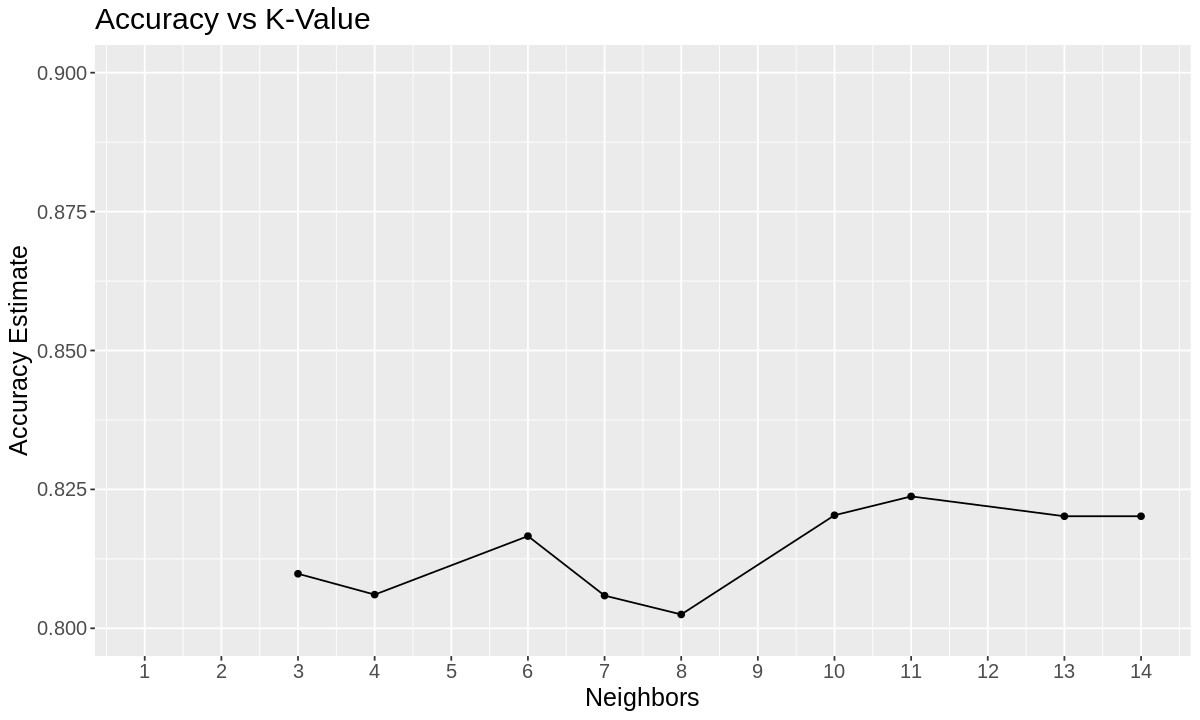

In [64]:
set.seed(3000) # DO NOT REMOVE
options(repr.plot.height = 6, repr.plot.width = 10)

uk_resample_fit <- workflow() %>%
       add_recipe(uk_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = uk_vfold, grid = 10) %>%
       collect_metrics()

accuracies <- uk_resample_fit %>% 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.8, 0.9)) + # adjusting the y-axis
       ggtitle("Accuracy vs K-Value") + 
       theme(text = element_text(size = 15))

cross_val_plot

*Figure 2: a line plot using the accuracies dataset with neighbors on the x-axis and the mean on the y-axis*

From the plot, we see that the accuracy seems to peaks at **K = 11**. 

### 2.7 Build the Model

Now that we've chosen the best K, we can build our model. 

In [65]:
set.seed(3000) # DO NOT REMOVE

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
        set_engine("kknn") %>%
        set_mode("classification")

uk_fit <- workflow() %>%
       add_recipe(uk_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = training_data) 

In [66]:
set.seed(3000) # DO NOT REMOVE

uk_predictions <- predict(uk_fit, testing_data) %>%
                bind_cols(testing_data)

uk_predictions_head <- head(uk_predictions)
kable(uk_predictions_head, caption = "5 Prediction")

uk_metrics <- uk_predictions %>%
        metrics(truth = UNS, estimate = .pred_class)

kable(uk_metrics, caption = "6 Accuracy")

uk_conf_mat <- uk_predictions %>% 
        conf_mat(truth = UNS, estimate = .pred_class)



Table: 5 Prediction

|.pred_class |  STG|  SCG|  STR|  LPR|  PEG|UNS      |
|:-----------|----:|----:|----:|----:|----:|:--------|
|Low         | 0.08| 0.08| 0.08| 0.98| 0.24|Low      |
|Middle      | 0.09| 0.15| 0.40| 0.10| 0.66|Middle   |
|High        | 0.00| 0.00| 0.50| 0.20| 0.85|High     |
|High        | 0.18| 0.18| 0.55| 0.30| 0.81|High     |
|High        | 0.12| 0.12| 0.75| 0.35| 0.80|High     |
|Very Low    | 0.05| 0.07| 0.70| 0.01| 0.05|Very Low |



Table: 6 Accuracy

|.metric  |.estimator | .estimate|
|:--------|:----------|---------:|
|accuracy |multiclass | 0.8991597|
|kap      |multiclass | 0.8607644|

In [67]:
uk_conf_mat ## Confusion Matrix

          Truth
Prediction Very Low High Low Middle
  Very Low       14    0   1      0
  High            0   25   0      0
  Low             1    0  37      5
  Middle          0    5   0     31

The reported accuracy of the model ended up being 89.9% as shown in Table 6. In order to improve the accuracy of this model, perhaps having a larger training dataset for the model would be beneficial. 

## 3.0 Discussion 

### 3.1 What We Found

In this report, we use K-nearest neighbors classification to explore whether student exam performance can accurately predict the student's knowledge level in that material. What we find is the most important predictor to UNS(knowledge level) is PEG(exam performance of user for goal objects) and there is a strongly positive relationship between PEG and UNS, the higher your grade of goal objects exam, the better you master goal objects. what's more, we found STG (The degree of study time for goal object materails), SCG (The degree of repetition number of user for goal object materails), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object) have weakly postive relation with UNS. In those 4 predictor, the value between 0-0.5, there is no clear pattern showing the relation with UNS, the value between 0.5-1, the higher the value, the better students master goal objects.

### 3.2 Whether this is what you expected to find?

Generally, the result is close to we expectation. What is different is that we expected that STG and SCG should have positive relationship with UNS in entire value 0-1, however, the true result showed that only value from 0.5-1 have clear pattern, value from 0-0.5 doesn't have clear pattern at all.

### 3.3 What impact could such findings have?

We can claim that exam is a efficient tool to test student's understanding of goal materials.

### 3.4  What future questions could this lead to?

We can further focus on why sometimes study time and repetition don't enhance the comprehension of goal material, how can students improve the study efficency and what is the best study time per day to maintain high efficency.

### 4.0  References

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). Developing intuitive knowledge classifier and modeling of users' domain dependent data      in web. Knowledge-Based Systems, 37, 283-295.

Tomic, B., & Milic, T. (2013). Automated interpretation of key performance indicator values and its application in education. Knowledge-        Based Systems, 37, 250-260.